In [25]:
from tensorflow import keras
from tensorflow.keras import Input,Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
import tensorflow as tf
from keras.metrics import Mean
from keras.losses import binary_crossentropy
import numpy as np
from keras.optimizers import Adam
import matplotlib.pyplot as plt

In [11]:
latent_dim = 2

encoder_inputs = Input(shape=(28, 28, 1))
x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = Flatten()(x)
x = Dense(16, activation="relu")(x)

z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
encoder = Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

In [12]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 14, 14, 32)   320         ['input_5[0][0]']                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_6[0][0]']               
                                                                                                  
 flatten_3 (Flatten)            (None, 3136)         0           ['conv2d_7[0][0]']               
                                                                                            

**Latent-space-sampling layer**

In [14]:
class Sampler(layers.Layer):
    
    def call(self, z_mean, z_log_var):
    
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

**VAE decoder network, mapping latent space points to images**

In [17]:
latent_inputs = Input(shape=(latent_dim,))
x = Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")

In [18]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_5 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 1)         289 

**VAE model with custom `train_step()`**

In [21]:
class VAE(Model):
    
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        
        with tf.GradientTape() as tape:
            
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(binary_crossentropy(data, reconstruction), axis=(1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

**Training the VAE**

In [24]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=Adam(), run_eagerly=True)
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 21s 26ms/step - total_loss: 211.3921 - reconstruction_loss: 209.0554 - kl_loss: 2.3365
Epoch 2/30
547/547 [==============================] - 14s 26ms/step - total_loss: 184.9942 - reconstruction_loss: 182.6615 - kl_loss: 2.3326
Epoch 3/30
547/547 [==============================] - 14s 25ms/step - total_loss: 172.9250 - reconstruction_loss: 169.5839 - kl_loss: 3.3409
Epoch 4/30
547/547 [==============================] - 14s 25ms/step - total_loss: 162.5471 - reconstruction_loss: 158.5736 - kl_loss: 3.9737
Epoch 5/30
547/547 [==============================] - 14s 25ms/step - total_loss: 159.2707 - reconstruction_loss: 155.1641 - kl_loss: 4.1066
Epoch 6/30
547/547 [==============================] - 14s 25ms/step - total_loss: 157.2947 - reconstruction_loss: 153.1430 - kl_loss: 4.1517
Epoch 7/30
547/547 [==============================] - 14s 26ms/step - total_loss: 155.9595 - reconstruction_loss: 151.7852 - kl_loss: 4.1745
Epoch 8/30
54

**Sampling a grid of images from the 2D latent space**

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


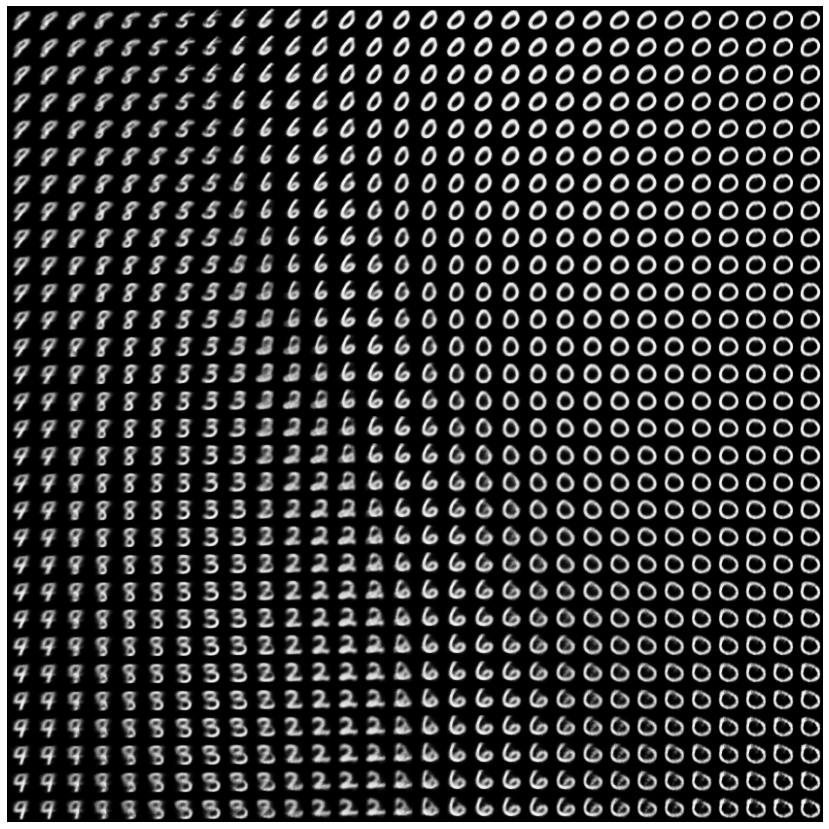

In [26]:


n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")